In [2]:
import os
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
from nltk.tokenize import TweetTokenizer

import matplotlib as plt
%matplotlib inline

/Users/NLamm/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/NLamm/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Import data 

https://github.com/t-davidson/hate-speech-and-offensive-language/tree/master/data

"The data are stored as a CSV and as a pickled pandas dataframe (Python 2.7). Each data file contains 5 columns:

- count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).
- hate_speech = number of CF users who judged the tweet to be hate speech.
- offensive_language = number of CF users who judged the tweet to be offensive.
- neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
- class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither"

In [2]:
df = pd.read_csv('data/labeled_data.csv', index_col=0)
print(df.shape)
df.head()

(24783, 6)


,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


# Process data

## Tokenize and encode

In [3]:
# Initialize the tokenizer
tk = TweetTokenizer()

# Define special tokens
SOS = 'SOS_TOKEN'
EOS = 'EOS_TOKEN'
PAD = 'PAD_TOKEN'
UNK = '<unknown>'

vocab = set()

# Begin mapping dictionaries for token-->word and word-->token
word_to_idx = {PAD:0, SOS:1, EOS:2, UNK:3}
idx_to_word = {0:PAD, 1:SOS, 2:EOS, 3:UNK}

# Build word_to_idx and idx_to_word dictionaries
for msg in df['tweet'].values:
    for word in tk.tokenize(msg):
        if word not in vocab:
            vocab.add(word)
            word_to_idx[word] = len(word_to_idx)
            idx_to_word[len(idx_to_word)] = word

In [4]:
def sentence_to_idx(sentence_str):
    """Transform sentence strings into index arrays"""
    sentence_as_idx = [1] # Begin with SOS token
    
    for word in tk.tokenize(sentence_str):
        if word_to_idx.get(word):
            sentence_as_idx.append(word_to_idx[word])
        else:
            sentence_as_idx.append(word_to_idx[UNK])
            
    sentence_as_idx.append(2) # End with EOS token
    return sentence_as_idx

df['msg_idx'] = df['tweet'].apply(sentence_to_idx)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,msg_idx
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[1, 4, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14..."
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[1, 4, 4, 4, 5, 30, 7, 31, 32, 33, 29, 34, 35,..."
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[1, 4, 4, 4, 5, 44, 45, 4, 4, 4, 5, 46, 47, 7,..."
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[1, 4, 4, 4, 5, 61, 7, 62, 53, 63, 64, 9, 65, 2]"
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[1, 4, 4, 4, 5, 66, 7, 67, 60, 11, 68, 14, 69,..."


## Load pretrained embeddings

In [6]:
# Ref: https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

local_glove_dir = os.getenv("GLOVE_DIR")  # Local directory with downloaded glove embeddings
glove_file = os.path.join(local_glove_dir, "glove.twitter.27B.200d.txt")

EMBEDDING_DIM = 200

embeddings_dict = {}
f = open(glove_file)
for line in f:
    values = line.split()
    word, coefs = values[0], torch.FloatTensor(np.asarray(values[1:], dtype='float32'))
    if word in vocab:
        embeddings_dict[word] = coefs
    elif word in ['eos','sos']:
        embeddings_dict[word] = coefs
f.close()

print("DONE: Prepared GloVe embeddings for {} words.".format(len(embeddings_dict)))

DONE: Prepared GloVe embeddings for 14011 words.


In [7]:
# Use GloVe embeddings for SOS and EOS tokens,
# according to the keys we used during encoding:
embeddings_dict[SOS] = embeddings_dict['sos']
embeddings_dict[EOS] = embeddings_dict['eos']

# Use zeros for UNK and padding
#(the padding embedding doesn't matter, will be ignored)
embeddings_dict[UNK] = torch.zeros(EMBEDDING_DIM)
embeddings_dict[PAD] = torch.zeros(EMBEDDING_DIM)

## Prepare target columns: `is_hate_speech` and `is_offensive_language`

In [8]:
df['is_hate_speech'] = df['class'] == 0
df['is_offensive_language'] = df['class'] == 1

print("Classes:")
print(df['class'].value_counts())

df.head()

Classes:
1    19190
2     4163
0     1430
Name: class, dtype: int64


,count,hate_speech,offensive_language,neither,class,tweet,msg_idx,is_hate_speech,is_offensive_language
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,"[1, 4, 4, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",False,False
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,"[1, 4, 4, 4, 5, 30, 7, 31, 32, 33, 29, 34, 35,...",False,True
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,"[1, 4, 4, 4, 5, 44, 45, 4, 4, 4, 5, 46, 47, 7,...",False,True
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,"[1, 4, 4, 4, 5, 61, 7, 62, 53, 63, 64, 9, 65, 2]",False,True
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,"[1, 4, 4, 4, 5, 66, 7, 67, 60, 11, 68, 14, 69,...",False,True


# Train/test/val split

In [10]:
def get_train_test_val_splits(data, val_pct=.15, test_pct=.15):
    """
    data: np.array shape: (n observations, features)
    returns: np.array of shuffled, randomly assigned observations
        for training, validation, and test datasets
    
    Ex: train_data, val_data, test_data = get_train_test_val_splits(data)
    """

    n_observations = data.shape[0]
    all_idx = np.arange(n_observations)
    np.random.shuffle(all_idx)

    train_pct = 1 - val_pct - test_pct

    train_idx = all_idx[:int(np.floor(n_observations*train_pct))]
    val_idx = all_idx[int(np.floor(n_observations*train_pct)):-int(np.floor(n_observations*test_pct))]
    test_idx = all_idx[-int(np.floor(n_observations*test_pct)):]

    train_data = np.array(data)[train_idx] 
    val_data = np.array(data)[val_idx] 
    test_data = np.array(data)[test_idx] 
    
    return train_data, val_data, test_data

data = np.asarray(df)
train_data, val_data, test_data = get_train_test_val_splits(data)
print("""
Training set: {}
Validation set: {}
Test set: {}""".format(train_data.shape, val_data.shape, test_data.shape))


Training set: (17348, 9)
Validation set: (3718, 9)
Test set: (3717, 9)


# Prepare training data

## Get glove embeddings for each word in training set, and use UNK embedding (torch.zeros(200)) if not found

In [11]:
BATCH_SIZE = 10
MAX_LENGTH = 30

def dataset_into_batch_idx(data, batch_size, shuffle=True, max_batches_to_return=None):
    """
    Return indices of the entire dataset arranged into batches.
     
    Inputs:
    data: np.array of data, shape (n_observations, features)
    batch_size: int
    max_batches_to_return: (optional) Number of batches to return
    
    Returns:
    np.array of indices. Dim 0: batches, Dim 1: indices within a batch.
    """
    
    
    # Make sure there is enough data for at least 1 batch
    if data.shape[0] < batch_size:
        print("Not enough data for one batch.")
        return None
    
    idx = np.arange(data.shape[0])
    
    # Shuffle indices
    if shuffle:
        np.random.shuffle(idx)
    
    # Get rid of of any rows if there will be a remainder when divided data size by batch size
    remainder = idx.shape[0] % batch_size
    if remainder > 0:
        idx = idx[:-remainder]
    
    # Rehape to ((-1, batch_size))
    idx = idx.reshape((-1, batch_size))
    
    # Keep only enough rows for batch_size x max_batches_to_return
    if max_batches_to_return:
        idx = idx[:max_batches_to_return]    
    
    return idx

In [12]:
# Example:
train_idx = dataset_into_batch_idx(train_data, BATCH_SIZE)

In [13]:
def prepare_batch(data, batch_idx, batch_size=BATCH_SIZE,
                  max_seq_length=MAX_LENGTH,
                  target='is_hate_speech'):

    """
    Prepare source and target tensors for ONE batch
    
    Inputs:
    data:
    batch_idx: array of indices for a batch
    batch_size
    target: 'is_hate_speech' (default) or 'is_offensive_language'
    

    Returns:
        tuple:
        Variable tensor of embedded source sequence
            (batch size, max seq length in batch,
             embedding dim),
        Variable tensor of targets
            (batch size),
        Tensor of original sequence lenths before
            padding (batch size)

    """

    batch = data[batch_idx]

    batch_source = batch[:,6] # 6 is index of the encoded words
    
    # Get length of each sequence in the batch (or MAX_LENGTH if it's greater than that)
    batch_seq_lengths = torch.LongTensor([min(len(seq),max_seq_length) for seq in batch_source])

    # Get max sequence length in batch, or MAX_LENGTH -- whichever is smaller
    max_seq_length_in_batch = min(max([len(seq) for seq in batch_source]),
                                  max_seq_length)

    embedded_seqs = []
    for seq in batch_source: # For each sequence in batch
        seq_embedded = []
        seq = seq[:max_seq_length_in_batch] # If sequence is longer than max length, cut if off
        for word_idx in seq: # Get the GloVe embedding for each word in the sequence
            if idx_to_word[word_idx] in embeddings_dict:
                word_embedding = embeddings_dict[idx_to_word[word_idx]]
            else: # If no GloVe embedding for the word, use the UNK embedding (zeros)
                word_embedding = embeddings_dict[UNK]
            seq_embedded.append(word_embedding)
        for padding in range(max_seq_length_in_batch - len(seq)):
            seq_embedded.append(embeddings_dict[PAD])
        embedded_seqs.append(torch.stack(seq_embedded)) # Stack embedded sequence into a tensor 

    batch_source_embedded = Variable(torch.stack(embedded_seqs)) # Stack embadded sequences in the batch into a tensor

    target_idx = 7 if target == 'is_hate_speech' else 8
    batch_target = torch.FloatTensor(batch[:,7].astype(int))
    
    # Sort by original (unpadded) sequence length, descending
    _, sort_indices = torch.sort(batch_seq_lengths, dim=0, descending=True) 
    batch_source_embedded = batch_source_embedded[sort_indices,:,:]
    batch_target = batch_target[sort_indices]
    batch_seq_lengths = batch_seq_lengths[sort_indices]

    return batch_source_embedded, Variable(batch_target), batch_seq_lengths

In [14]:
# Example:
batch_idx = train_idx[0]

batch_source_embedded, batch_target, batch_seq_lengths = prepare_batch(train_data, batch_idx)

# Models

In [20]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class LSTMClassifier(nn.Module):
    """
    Bidirectional LSTM classifier
    """

    def __init__(self, hidden_dim, batch_size, embedding_size, num_layers=1, dropout=0, verbose=False):
        super(LSTMClassifier, self).__init__()
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.verbose = verbose
        self.inner_hidden_dim = 200
        
        self.num_directions = 2 # Bidirectional

        self.lstm = nn.LSTM(embedding_size, hidden_dim, num_layers, batch_first=True, bidirectional=True)
        self.dropout1 = nn.Dropout(dropout)
        self.fc1 = nn.Linear(hidden_dim*2, self.inner_hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(self.inner_hidden_dim, 1)
        self.sig = nn.Sigmoid()

    def init_hidden(self):
        # Tuple of two tensors: (h_0, c_0)
        return (torch.zeros(self.num_layers*self.num_directions, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers*self.num_directions, self.batch_size, self.hidden_dim))

    def forward(self, input, unpadded_lengths):

        if self.verbose:
            print('Input:',input.size())
        
        packed = pack_padded_sequence(input, unpadded_lengths, batch_first=True)
        if self.verbose:
            print("After packing:",packed.data.size())
        
        packed_output, (hidden, cell) = self.lstm(packed, self.hidden)
        
        if self.verbose:
            print('Packed output after LSTM:',packed_output.data.size())
        
        # Get last hidden state for each sequence
        # For each batch, concat the last hidden state from the forward LSTM
        # with the last hidden state from the reverse LSTM.
        # (aka get the hidden state from the last _timestep_)
        
        def unzip(t):
            """
            Returns a tensor where dimension 0 is the layer. So with 3 layers, shape[0] = 3.
            Along each layer, the forward and backward hidden states are concatenated.
            """
            return torch.cat([t[0:t.size(0):2], t[1:t.size(0):2]], 2)
        
        # Get the forward and backward hidden states for the top layer
        out = unzip(hidden)[-1]
        
        out = self.dropout1(out)
        
        if self.verbose:
            print('Top hidden layer from LSTM:', out.size())
            
        out = self.relu1(self.fc1(out))
        out = self.dropout1(out)
        out = self.sig(self.fc2(out))
        out = out.squeeze(1)
        
        if self.verbose:
            print('Output:', out.size())
            
        return out

In [16]:
# Example:
model = LSTMClassifier(hidden_dim=300, batch_size=BATCH_SIZE, embedding_size=EMBEDDING_DIM,
                       num_layers=3, dropout=0, verbose=True)

# Example batch:
train_idx = dataset_into_batch_idx(train_data, BATCH_SIZE)
batch_idx = train_idx[0]
batch_source_embedded, batch_target, batch_seq_lengths = prepare_batch(train_data, batch_idx)

model.hidden = model.init_hidden()
output = model(batch_source_embedded, batch_seq_lengths)

Input: torch.Size([10, 30, 200])
After packing: torch.Size([186, 200])
Packed output after LSTM: torch.Size([186, 600])
Top hidden layer from LSTM: torch.Size([10, 600])
Output: torch.Size([10])


# Train model

In [17]:
import torch.optim as optim
import datetime

torch.manual_seed(1)

In [56]:
def train_model(target, hidden_dim, batch_size,
                epochs, print_every, log_every,
                num_layers, dropout, print_summary=True):
    
    """Full training sequence for the model"""

    model = LSTMClassifier(hidden_dim=hidden_dim,
                           batch_size=batch_size,
                           embedding_size=EMBEDDING_DIM,
                           num_layers=num_layers,
                           dropout=dropout,
                           verbose=False)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    losses, validation_losses = [], [] # for plotting losses
    offset_count = 0

    for epoch in range(epochs):
        print("\n=== Epoch {} ===".format(epoch+1))

        # Get shuffled indices for the entire training data set,
        # organized into batches:
        train_idx = dataset_into_batch_idx(train_data, batch_size)
        print("{} batches in epoch".format(train_idx.shape[0]))

        for i in range(train_idx.shape[0]):  # Iterate through each batch
            batch_idx = train_idx[i]
            batch_source_embedded, batch_target, batch_seq_lengths = prepare_batch(train_data, batch_idx, target=target)

            model.zero_grad()
            model.hidden = model.init_hidden()

            output = model(batch_source_embedded, batch_seq_lengths)

            loss = criterion(output, batch_target)
            loss.backward()
            optimizer.step()

            # Log
            if i % log_every == 0:
                losses.append((i+offset_count, loss)) # for plotting losses

            # Validate
            if i % print_every == 0:
                print('\nStep {}:'.format(i))
                print(datetime.datetime.now().strftime("%m/%d/%y %H:%M:%S"))
                print('Training loss: {:.3f}'.format(loss))
                with torch.no_grad():
                    val_idx = dataset_into_batch_idx(val_data, batch_size, max_batches_to_return=1)
                    batch_source_embedded, batch_target, batch_seq_lengths = prepare_batch(train_data, val_idx[0])
                    model.hidden = model.init_hidden()
                    output = model(batch_source_embedded, batch_seq_lengths)
                    validation_loss = criterion(output, batch_target)
                    print('Validation loss: {:.3f}'.format(validation_loss))
                    validation_losses.append((i+offset_count,validation_loss)) # for plotting losses

        offset_count += train_idx.shape[0] # for logging the step count after the first epoch
    print("=== Done Training ===")
    
    if print_summary:
        # Print parameters
        print("\n=== SUMMARY ==")
        print("MODEL PARAMETERS")
        print("Target:", target)
        print("Hidden dim:", hidden_dim)
        print("Number of layers:", num_layers)
        print("Dropout:", dropout)
        print("\nTRAINING PARAMETERS")
        print("Epochs:", epochs)
        print("Batch size:", batch_size)
        
        # Plot training and validation losses
        plt.figure(figsize=(20,4))
        plt.plot([i for i,loss in losses], [loss.item() for i,loss in losses], 'g-', linewidth=2)
        plt.plot([i for i,loss in validation_losses], [loss.item() for i,loss in validation_losses], 'bo--', linewidth=2)
        plt.legend(['Training loss','Validation loss'])
        plt.xlabel('Batches')
        plt.ylabel('Loss')
        plt.show()
    
    return losses, validation_losses


=== Epoch 1 ===
346 batches in epoch

Step 0:
11/12/18 16:34:21
Training loss: 0.729
Validation loss: 0.726

Step 150:
11/12/18 16:35:14
Training loss: 0.283
Validation loss: 0.289

Step 300:
11/12/18 16:36:05
Training loss: 0.220
Validation loss: 0.179

=== Epoch 2 ===
346 batches in epoch

Step 0:
11/12/18 16:36:21
Training loss: 0.236
Validation loss: 0.228

Step 150:
11/12/18 16:37:12
Training loss: 0.064
Validation loss: 0.168

Step 300:
11/12/18 16:38:07
Training loss: 0.280
Validation loss: 0.177

=== Epoch 3 ===
346 batches in epoch

Step 0:
11/12/18 16:38:22
Training loss: 0.097
Validation loss: 0.111

Step 150:
11/12/18 16:39:14
Training loss: 0.392
Validation loss: 0.261

Step 300:
11/12/18 16:40:05
Training loss: 0.137
Validation loss: 0.238

=== Epoch 4 ===
346 batches in epoch

Step 0:
11/12/18 16:40:21
Training loss: 0.095
Validation loss: 0.183

Step 150:
11/12/18 16:41:12
Training loss: 0.213
Validation loss: 0.177

Step 300:
11/12/18 16:42:03
Training loss: 0.238
Val

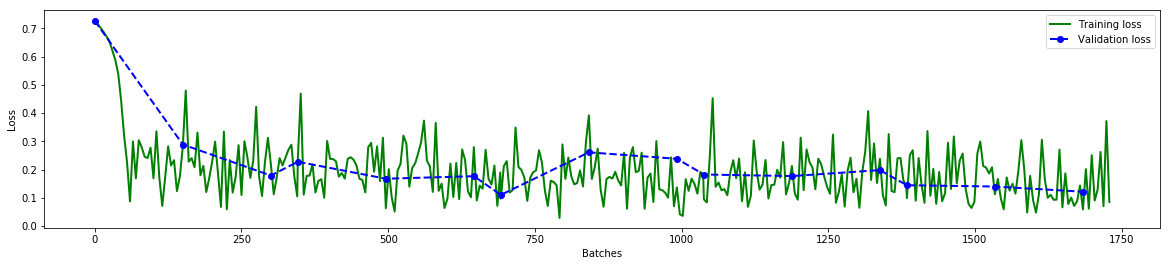

In [58]:
# Target: is_hate_speech
losses, validation_losses = train_model(target='is_hate_speech', hidden_dim=100,
                                        batch_size=50, epochs=5,
                                        print_every=150, log_every=5,
                                        num_layers=4, dropout=0.1)


=== Epoch 1 ===
346 batches in epoch

Step 0:
11/12/18 16:44:19
Training loss: 0.669
Validation loss: 0.670

Step 150:
11/12/18 16:45:10
Training loss: 0.226
Validation loss: 0.185

Step 300:
11/12/18 16:46:01
Training loss: 0.112
Validation loss: 0.178

=== Epoch 2 ===
346 batches in epoch

Step 0:
11/12/18 16:46:17
Training loss: 0.180
Validation loss: 0.333

Step 150:
11/12/18 16:47:08
Training loss: 0.159
Validation loss: 0.041

Step 300:
11/12/18 16:48:00
Training loss: 0.060
Validation loss: 0.128

=== Epoch 3 ===
346 batches in epoch

Step 0:
11/12/18 16:48:16
Training loss: 0.145
Validation loss: 0.264

Step 150:
11/12/18 16:49:07
Training loss: 0.043
Validation loss: 0.272

Step 300:
11/12/18 16:49:58
Training loss: 0.076
Validation loss: 0.114

=== Epoch 4 ===
346 batches in epoch

Step 0:
11/12/18 16:50:14
Training loss: 0.119
Validation loss: 0.132

Step 150:
11/12/18 16:51:05
Training loss: 0.132
Validation loss: 0.124

Step 300:
11/12/18 16:51:58
Training loss: 0.173
Val

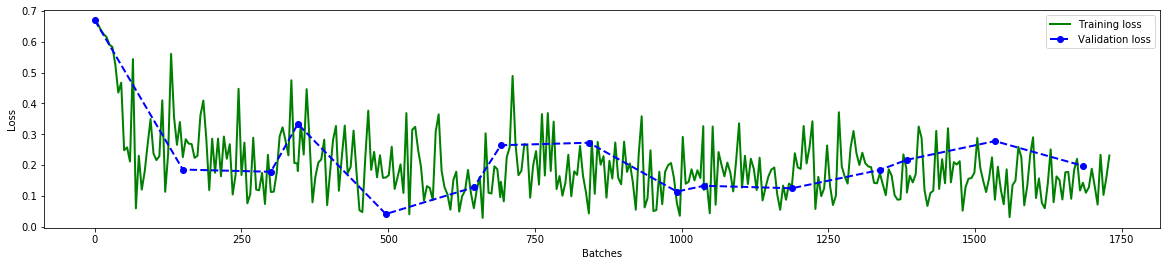

In [59]:
# Target: is_offensive_language
losses, validation_losses = train_model(target='is_offensive_language', hidden_dim=100,
                                        batch_size=50, epochs=5,
                                        print_every=150, log_every=5,
                                        num_layers=4, dropout=0.1)